In [1]:
#getting and working with data
import pandas as pd
import numpy as np
import re
import os

import scipy.stats as stats

from sklearn.preprocessing import StandardScaler, Normalizer, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split, cross_val_score, cross_val_predict, GridSearchCV, RandomizedSearchCV

from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC  
from sklearn import metrics
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, accuracy_score

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings; warnings.simplefilter('ignore')
np.set_printoptions(suppress=True)

In [2]:
path_EMA_MOSAIC = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Clinical projects/TILES/Data_googledrive/EMA surveys -MOSAIC.csv'
path_demog_prepost = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/Clinical projects/TILES/Data_googledrive/Demog, PRE, PST survey composites.csv'

In [3]:
#read in data_demog_prepost, contains demographic information and pre/post questionaires
data_demog_prepost = pd.read_csv(path_demog_prepost)
data_demog_prepost = pd.DataFrame(data = data_demog_prepost)
print('Original demog_prepost shape:\n', data_demog_prepost.shape, '\n')
#replace blnaks with nans
data_demog_prepost = data_demog_prepost.replace(' ', np.nan)
#ensure no replicate ID (eg one row per participant in study)
print('Original demog_prepost unique IDs:\n', data_demog_prepost['ID'].unique().shape, '\n')
print('Original demog_prepost missing value couts:\n', data_demog_prepost.isnull().sum(), '\n')
print('Original demog_prepost data types:\n', data_demog_prepost.info(), '\n')

Original demog_prepost shape:
 (212, 179) 

Original demog_prepost unique IDs:
 (212,) 

Original demog_prepost missing value couts:
 ID                                                                0
date_time                                                         0
shipley.vocab                                                     0
shipley.abs                                                       0
irb                                                               0
itp                                                               0
ocb                                                               0
inter.deviance                                                    0
org.deviance                                                      0
extraversion                                                      0
agreeableness                                                     0
conscientiousness                                                 0
neuroticism                                       

In [4]:
#split off demographic data
data_demog = data_demog_prepost[['ID', 'date_time', 'GenInst',
       'gender', 'age', 'bornUS', 'country', 'lang', 'englyrs', 'educ',
       'jobstat', 'occup', 'occup_TEXT', 'supervise', 'quantsup', 'size',
       'duration', 'income', 'record_id', 'redcap_event_name',
       'demographics_timestamp', 'race', 'ethnic', 'relationship',
       'pregnant', 'children', 'housing', 'household___1',
       'household___2', 'household___3', 'household___4', 'household___5',
       'household___6', 'household___7', 'currentposition',
       'position_other', 'certifications', 'nurseyears', 'shift', 'hours',
       'overtime', 'commute_type', 'commute_time', 'extrajob',
       'extrahours', 'student', 'demographics_complete']]
data_demog.head()

,ID,date_time,GenInst,gender,age,bornUS,country,lang,englyrs,educ,jobstat,occup,occup_TEXT,supervise,quantsup,size,duration,income,record_id,redcap_event_name,demographics_timestamp,race,ethnic,relationship,pregnant,children,housing,household___1,household___2,household___3,household___4,household___5,household___6,household___7,currentposition,position_other,certifications,nurseyears,shift,hours,overtime,commute_type,commute_time,extrajob,extrahours,student,demographics_complete
0,SD1001,2/20/2018,1,1,53,2,Guatemala,2,52,4,2,11,NaN,2,NaN,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,NaN,7,30,1,36,0,2,3,0,0,9,2
1,SD1002,2/22/2018,1,2,56,2,Viet Nam,2,38,4,2,10,NaN,1,2,4,10,7,11,prestudy_survey_arm_1,2018-02-27 11:33:22,3,0,3,0,0,1,0,0,0,1,0,0,0,1,NaN,6,12,1,36,24,2,3,0,0,9,2
2,SD1003,2/23/2018,1,2,25,1,NaN,1,NaN,4,2,10,NaN,2,NaN,4,2,4,9,prestudy_survey_arm_1,2018-02-26 21:23:59,3,0,1,0,0,2,0,0,0,0,1,0,0,1,NaN,7,1,1,36,12,2,1,0,0,9,2
3,SD1004,2/23/2018,1,2,26,1,NaN,1,NaN,3,2,10,NaN,2,NaN,4,7,2,19,prestudy_survey_arm_1,2018-03-01 12:54:07,6,1,1,0,0,2,1,0,0,0,0,0,0,2,NaN,7,5,1,36,0,6,1,0,0,9,2
4,SD1005,2/23/2018,1,2,31,2,mexico,2,25,5,2,10,NaN,2,NaN,4,10,4,8,prestudy_survey_arm_1,2018-02-24 21:27:46,1,1,2,0,2,2,1,0,1,1,0,0,0,2,NaN,7,10,1,36,0,2,2,0,0,9,2


In [5]:
print(data_demog.isna().sum())
print(data_demog.shape)
data_demog = data_demog.dropna(thresh = 100, axis = 1)
print(data_demog.shape)
data_demog['uid'] = data_demog['ID']
data_demog.head()

ID                          0
date_time                   0
GenInst                     0
gender                      0
age                         0
bornUS                      0
country                   119
lang                        0
englyrs                   127
educ                        0
jobstat                     0
occup                       0
occup_TEXT                192
supervise                   1
quantsup                  157
size                        0
duration                    1
income                      0
record_id                   4
redcap_event_name           4
demographics_timestamp      4
race                       45
ethnic                      5
relationship               21
pregnant                    6
children                    7
housing                     4
household___1               4
household___2               4
household___3               4
household___4               4
household___5               4
household___6               4
household_

,ID,date_time,GenInst,gender,age,bornUS,lang,educ,jobstat,occup,supervise,size,duration,income,record_id,redcap_event_name,demographics_timestamp,race,ethnic,relationship,pregnant,children,housing,household___1,household___2,household___3,household___4,household___5,household___6,household___7,currentposition,certifications,nurseyears,shift,hours,overtime,commute_type,commute_time,extrajob,extrahours,student,demographics_complete,uid
0,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2,SD1001
1,SD1002,2/22/2018,1,2,56,2,2,4,2,10,1,4,10,7,11,prestudy_survey_arm_1,2018-02-27 11:33:22,3,0,3,0,0,1,0,0,0,1,0,0,0,1,6,12,1,36,24,2,3,0,0,9,2,SD1002
2,SD1003,2/23/2018,1,2,25,1,1,4,2,10,2,4,2,4,9,prestudy_survey_arm_1,2018-02-26 21:23:59,3,0,1,0,0,2,0,0,0,0,1,0,0,1,7,1,1,36,12,2,1,0,0,9,2,SD1003
3,SD1004,2/23/2018,1,2,26,1,1,3,2,10,2,4,7,2,19,prestudy_survey_arm_1,2018-03-01 12:54:07,6,1,1,0,0,2,1,0,0,0,0,0,0,2,7,5,1,36,0,6,1,0,0,9,2,SD1004
4,SD1005,2/23/2018,1,2,31,2,2,5,2,10,2,4,10,4,8,prestudy_survey_arm_1,2018-02-24 21:27:46,1,1,2,0,2,2,1,0,1,1,0,0,0,2,7,10,1,36,0,2,2,0,0,9,2,SD1005


In [83]:
#read in MOSAIC EMA 
data_EMA = pd.read_csv(path_EMA_MOSAIC)
data_EMA = pd.DataFrame(data = data_EMA)
print('Original MOSAIC EMA shape:\n', data_EMA.shape, '\n')
print('Original MOSAIC EMA survey type counts:\n', data_EMA['survey_type'].value_counts(), '\n')
print('Original MOSAIC EMA missing value couts:\n', data_EMA.isnull().sum(), '\n')
print('Original MOSAIC EMA data types:\n', data_EMA.info(), '\n')

Original MOSAIC EMA shape:
 (11398, 25) 

Original MOSAIC EMA survey type counts:
 health         5619
job            4964
personality     815
Name: survey_type, dtype: int64 

Original MOSAIC EMA missing value couts:
 uid                    0
survey_type            0
timestamp              0
itp_mgt             9027
irb_mgt             9024
ocb_mgt             9037
cwb_mgt             9039
neu_mgt            10593
con_mgt            10596
ext_mgt            10593
agr_mgt            10593
ope_mgt            10593
pos_af_mgt           120
neg_af_mgt           121
anxiety_mgt          111
stress_mgt            86
alcohol_mgt         5845
tobacco_mgt         5847
exercise_mgt        5861
sleep_mgt           5842
interaction_mgt        0
activity_mgt          30
location_mgt          53
event_mgt             68
work_mgt            6497
dtype: int64 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11398 entries, 0 to 11397
Data columns (total 25 columns):
uid                11398 non-nul

In [84]:
#create date column from timestamp data
data_EMA['date'] = data_EMA['timestamp'].str.split(' ', expand=True)[0]

In [85]:
data_EMA['date'].describe()

count          11398
unique           145
top       2018-05-04
freq             166
Name: date, dtype: object

In [86]:
data_EMA.groupby(['survey_type', 'uid'])['date'].unique()

survey_type  uid   
health       SD1001                 [2018-03-06, 2018-03-09, 2018-03-12]
             SD1002    [2018-03-06, 2018-03-12, 2018-03-14, 2018-03-1...
             SD1003    [2018-03-06, 2018-03-09, 2018-03-12, 2018-03-1...
             SD1004    [2018-03-06, 2018-03-09, 2018-03-12, 2018-03-1...
             SD1005    [2018-03-09, 2018-03-12, 2018-03-14, 2018-03-1...
             SD1006    [2018-03-09, 2018-03-12, 2018-03-14, 2018-03-1...
             SD1008    [2018-03-06, 2018-03-09, 2018-03-12, 2018-03-1...
             SD1009    [2018-03-06, 2018-03-09, 2018-03-12, 2018-03-1...
             SD1010    [2018-03-09, 2018-03-12, 2018-03-14, 2018-03-1...
             SD1011    [2018-03-06, 2018-03-09, 2018-03-12, 2018-03-1...
             SD1012    [2018-03-06, 2018-03-09, 2018-03-12, 2018-03-1...
             SD1013    [2018-03-06, 2018-03-09, 2018-03-12, 2018-03-1...
             SD1014    [2018-03-06, 2018-03-12, 2018-03-14, 2018-03-1...
             SD1015    [2018-03

In [91]:
data_EMA['date'].sort_values()

11177    2018-02-19
11108    2018-02-19
11326    2018-02-19
11111    2018-02-19
11260    2018-02-19
11098    2018-02-19
11261    2018-02-20
11178    2018-02-20
11112    2018-02-20
11327    2018-02-20
11179    2018-02-21
11113    2018-02-21
11328    2018-02-21
11099    2018-02-21
11329    2018-02-22
11180    2018-02-22
11262    2018-02-22
11114    2018-02-22
11181    2018-02-23
11263    2018-02-23
11330    2018-02-24
11264    2018-02-24
11182    2018-02-24
11331    2018-02-25
11265    2018-02-25
11332    2018-02-26
11266    2018-02-26
11333    2018-02-27
11183    2018-02-27
11100    2018-02-27
11115    2018-02-27
11116    2018-02-28
11334    2018-02-28
11184    2018-02-28
11267    2018-02-28
11117    2018-03-01
11335    2018-03-01
11185    2018-03-01
11118    2018-03-02
11268    2018-03-02
11186    2018-03-02
11336    2018-03-02
11187    2018-03-03
11119    2018-03-03
11269    2018-03-03
11337    2018-03-03
11120    2018-03-04
11338    2018-03-04
11270    2018-03-04
11188    2018-03-04


In [146]:
#plt.xticks(dates, fontsize=14)
dates = data_EMA['date'].unique()
import time
import datetime

time.mktime(datetime.datetime.strptime(d, "%Y-%m-%d").timetuple())


1520236800.0

<function matplotlib.pyplot.show(*args, **kw)>

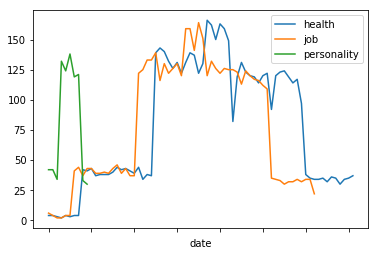

In [152]:
#stress mean by survey type and date
data_EMA[data_EMA['survey_type'] == 'health'].groupby(['date'])['uid'].count().plot.line()
data_EMA[data_EMA['survey_type'] == 'job'].groupby(['date'])['uid'].count().plot.line()
data_EMA[data_EMA['survey_type'] == 'personality'].groupby(['date'])['uid'].count().plot.line()
plt.legend(('health', 'job', 'personality'))
plt.show

In [11]:
data_EMA['time'].describe()

count        11398
unique        8359
top       18:01:21
freq            27
Name: time, dtype: object

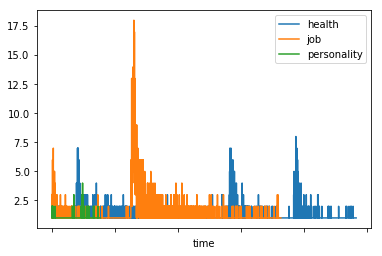

In [16]:
#create time column from timestamp data
data_EMA['time'] = data_EMA['timestamp'].str.split(' ', expand=True)[1]
#number of respondants by date
#number of respondents by survey type and time
data_EMA[data_EMA['survey_type'] == 'health'].groupby(['time'])['uid'].count().plot.line()
data_EMA[data_EMA['survey_type'] == 'job'].groupby(['time'])['uid'].count().plot.line()
data_EMA[data_EMA['survey_type'] == 'personality'].groupby(['time'])['uid'].count().plot.line()
plt.legend(('health', 'job', 'personality'))

In [17]:
#data consists of three different EMA surveys (health, job, personality), each with different set of questions asked
data_EMA.groupby('survey_type').count()

,uid,timestamp,itp_mgt,irb_mgt,ocb_mgt,cwb_mgt,neu_mgt,con_mgt,ext_mgt,agr_mgt,ope_mgt,pos_af_mgt,neg_af_mgt,anxiety_mgt,stress_mgt,alcohol_mgt,tobacco_mgt,exercise_mgt,sleep_mgt,interaction_mgt,activity_mgt,location_mgt,event_mgt,work_mgt,date,time
survey_type,,,,,,,,,,,,,,,,,,,,,,,,,,
health,5619,5619,0,0,0,0,0,0,0,0,0,5569,5568,5576,5587,5553,5551,5537,5556,5619,5604,5596,5592,0,5619,5619
job,4964,4964,2371,2374,2361,2359,0,0,0,0,0,4903,4903,4905,4919,0,0,0,0,4964,4950,4936,4927,4901,4964,4964
personality,815,815,0,0,0,0,805,802,805,805,805,806,806,806,806,0,0,0,0,815,814,813,811,0,815,815


In [173]:
data_EMA['event_mgt'].mean()

0.08879082082965578

In [18]:
#data consists of three different EMA surveys (health, job, personality), each with different set of questions asked
data_EMA.groupby(['survey_type', 'uid']).count()

timestamp  itp_mgt  irb_mgt  ocb_mgt  cwb_mgt  neu_mgt  con_mgt  ext_mgt  agr_mgt  ope_mgt  pos_af_mgt  neg_af_mgt  anxiety_mgt  stress_mgt  alcohol_mgt  tobacco_mgt  exercise_mgt  sleep_mgt  interaction_mgt  activity_mgt  location_mgt  event_mgt  work_mgt  date  time
survey_type uid                                                                                                                                                                                                                                                                                 
health      SD1001          3        0        0        0        0        0        0        0        0        0           3           3            3           3            3            3             3          3                3             3             3          3         0     3     3
            SD1002         32        0        0        0        0        0        0        0        0        0          32          32           32          32           32           32            32         32               32            32            32         32         0    32    32
            SD1003         33        0        0        0        0        0        0        0        0        0          33          33           33          33           33           33            33         33               33            33            33         33         0    33    33
            SD1004         20        0        0        0        0        0        0        0        0        0          19          19           19          20           18           18            18         18               20            20            20         20         0    20    20
            SD1005         24        0        0        0        0        0        0        0        0        0          24          24           24          24           23           24            23         24               24            24            24         24         0    24    24
            SD1006         34        0        0        0        0        0        0        0        0        0          34          34           34          34           34           34            34         34               34            34            34         34         0    34    34
            SD1008         24        0        0        0        0        0        0        0        0        0          24          24           24          24           24           24            24         24               24            24            24         24         0    24    24
            SD1009         34        0        0        0        0        0        0        0        0        0          34          34           34          34           34           34            34         34               34            34            34         34         0    34    34
            SD1010         31        0        0        0        0        0        0        0        0        0          31          31           31          31           31           31            31         31               31            31            31         31         0    31    31
            SD1011         26        0        0        0        0        0        0        0        0        0          26          26           26          26           25           25            25         25               26            26            26         26         0    26    26
            SD1012         30        0        0        0        0        0        0        0        0        0          30          30           30          30           30           30            30         30               30            30            30         30         0    30    30
            SD1013         35        0        0        0        0        0        0        0        0        0          35          35           35          35           35           35            35         34               35            35            35        

In [165]:
#data consists of three different EMA surveys (health, job, personality), each with different set of questions asked
data_EMA.groupby('uid')['survey_type'].count()

uid
SD1001    False
SD1002    False
SD1003    False
SD1004    False
SD1005    False
SD1006    False
SD1008    False
SD1009    False
SD1010    False
SD1011    False
SD1012    False
SD1013     True
SD1014    False
SD1015    False
SD1016    False
SD1017    False
SD1018    False
SD1019     True
SD1020    False
SD1021    False
SD1022    False
SD1023    False
SD1024    False
SD1025    False
SD1026    False
SD1027    False
SD1028     True
SD1029    False
SD1030     True
SD1031    False
SD1032    False
SD1033    False
SD1034    False
SD1035     True
SD1036    False
SD1037    False
SD1038    False
SD1039    False
SD1040     True
SD1041    False
SD1042    False
SD1043    False
SD1044    False
SD1045    False
SD1046    False
SD1047    False
SD1048    False
SD1049    False
SD1051    False
SD1052    False
SD1053    False
SD1054    False
SD1055    False
SD1056    False
SD1057    False
SD1058    False
SD1059    False
SD1060    False
SD1061    False
SD1062    False
SD1063    False
SD1064    False
SD10

In [20]:
data_EMA.groupby(['survey_type', 'stress_mgt'])['uid'].count()

survey_type  stress_mgt
health       1.0           2874
             2.0           1405
             3.0           1065
             4.0            186
             5.0             57
job          1.0           2392
             2.0           1191
             3.0           1064
             4.0            211
             5.0             61
personality  1.0            392
             2.0            221
             3.0            147
             4.0             34
             5.0             12
Name: uid, dtype: int64

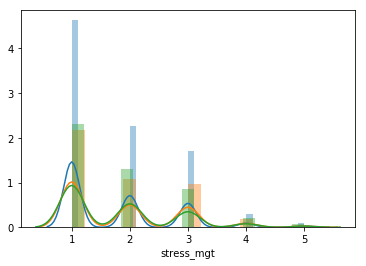

In [21]:
sns.distplot(data_EMA[data_EMA['survey_type'] == 'health']['stress_mgt'].dropna())
sns.distplot(data_EMA[data_EMA['survey_type'] == 'job']['stress_mgt'].dropna())
sns.distplot(data_EMA[data_EMA['survey_type'] == 'personality']['stress_mgt'].dropna())
plt.show()

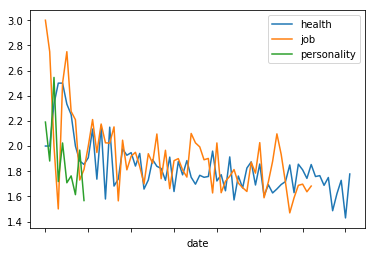

In [25]:
#stress mean by survey type and date
data_EMA[data_EMA['survey_type'] == 'health'].groupby(['date'])['stress_mgt'].mean().plot.line()
data_EMA[data_EMA['survey_type'] == 'job'].groupby(['date'])['stress_mgt'].mean().plot.line()
data_EMA[data_EMA['survey_type'] == 'personality'].groupby(['date'])['stress_mgt'].mean().plot.line()
plt.legend(('health', 'job', 'personality'))

In [23]:
#interested in stress as starting variable
data_EMA.groupby(['survey_type', 'stress_mgt']).mean()

itp_mgt    irb_mgt   ocb_mgt   cwb_mgt   neu_mgt   con_mgt   ext_mgt   agr_mgt   ope_mgt  pos_af_mgt  neg_af_mgt  anxiety_mgt  alcohol_mgt  tobacco_mgt  exercise_mgt  sleep_mgt  interaction_mgt  activity_mgt  location_mgt  event_mgt  work_mgt
survey_type stress_mgt                                                                                                                                                                                                                                                     
health      1.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   12.977344    5.517782     1.108711     0.325087     0.237404    269.787592   6.010794         2.067502      5.732777      1.910546   0.040376       NaN
            2.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   12.848962    6.263422     1.583155     0.292980     0.117014    250.433718   6.015409         1.916726      5.174377      2.177936   0.091103       NaN
            3.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   12.264151    7.937736     2.230914     0.192891     0.160833    257.022814   5.804429         1.860094      4.914554      2.235681   0.127700       NaN
            4.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   12.124324   11.383784     3.086022     0.266304     0.521505    145.010753   5.359730         1.919355      4.935484      2.204301   0.236559       NaN
            5.0              NaN        NaN       NaN       NaN       NaN       NaN       NaN       NaN       NaN   11.175439   14.315789     3.684211     0.149123     2.571429    117.263158   5.546491         1.807018      4.929825      1.912281   0.385965       NaN
job         1.0         4.530664  43.864130  7.580328  0.914661       NaN       NaN       NaN       NaN       NaN   12.861099    5.505245     1.093960          NaN          NaN           NaN        NaN         1.808528      4.959448      1.918444   0.053116  0.391779
            2.0         4.500000  44.315287  7.579200  1.004777       NaN       NaN       NaN       NaN       NaN   12.388186    6.216034     1.573232          NaN          NaN           NaN        NaN         1.730479      4.609572      1.988245   0.089840  0.535021
            3.0         4.445988  43.875576  7.577399  1.112150       NaN       NaN       NaN       NaN       NaN   12.320452    7.830349     2.159585          NaN          NaN           NaN        NaN         1.646617      4.052681      2.054614   0.173095  0.619093
            4.0         4.392435  42.900709  7.453901  1.312057       NaN       NaN       NaN       NaN       NaN   12.706161   10.781991     2.815166          NaN          NaN           NaN        NaN         1.649289      3.426540      2.018957   0.194313  0.672986
            5.0         4.363636  41.787879  7.181818  1.424242       NaN       NaN       NaN       NaN       NaN   11.983607   14.098361     3.475410          NaN          NaN           NaN        NaN         1.491803      4.295082      2.049180   0.393443  0.540984
personality 1.0              NaN        NaN       NaN       NaN  2.189744  4.136598  3.207692  3.973077  3.368895   12.774359    5.469231     1.092308          NaN          NaN           NaN        NaN         1.928571      5.237245      1.905612   0.038265       NaN
            2.0              NaN        NaN       NaN       NaN  2.506849  4.155963  3.077626  3.785388  3.247727   12.086364    6.463636     1.554545          NaN          NaN           NaN        NaN         1.796380      4.280543      1.986425   0.049774       NaN
            3.0              NaN        NaN       NaN       NaN  2.612245  4.034014  3.292517  3.755102  3.350340   12.197279    7.585034     2.163265          NaN          NaN           NaN        NaN         1.639456      4.496599      2.040816   0.142857       NaN
     

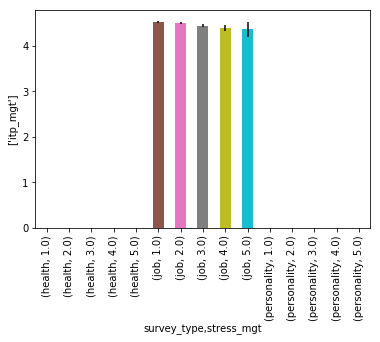

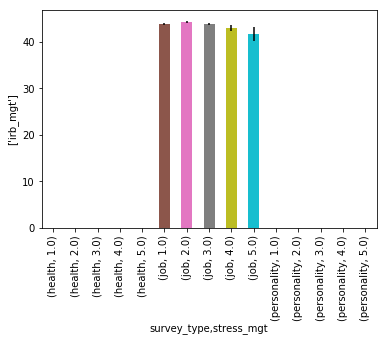

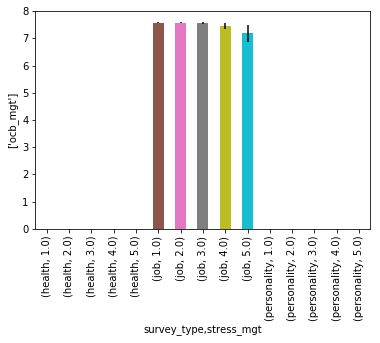

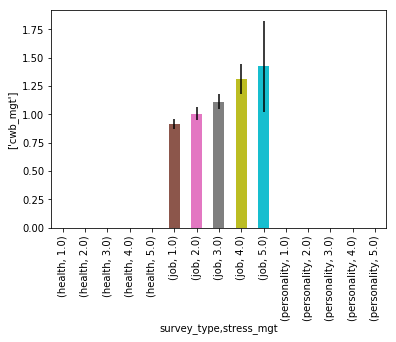

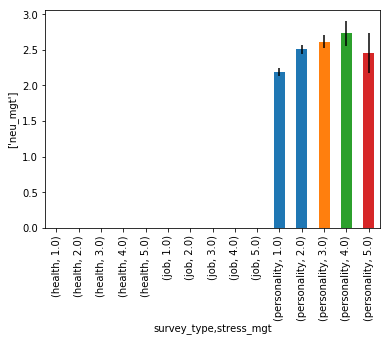

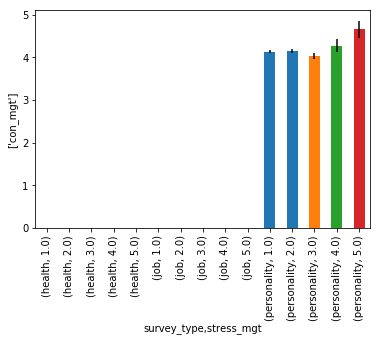

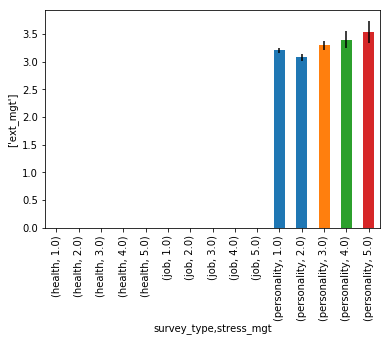

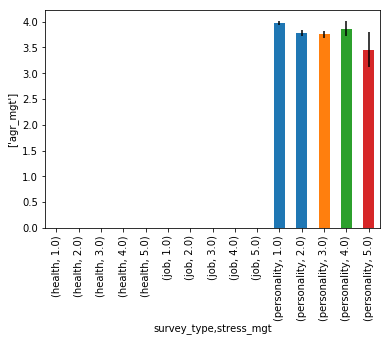

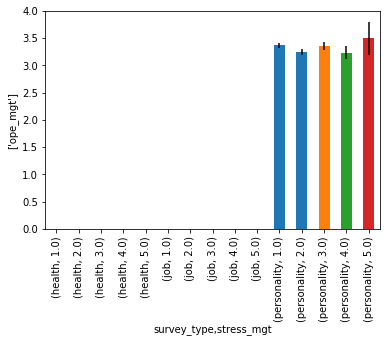

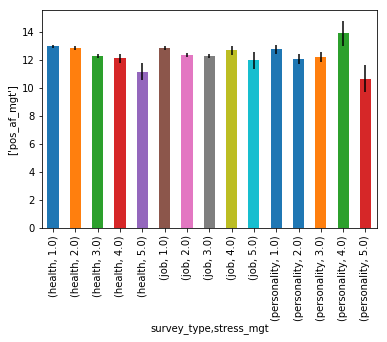

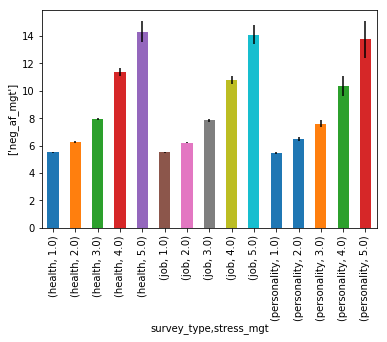

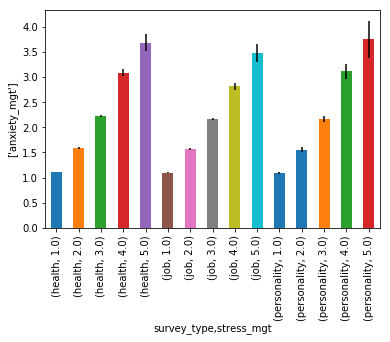

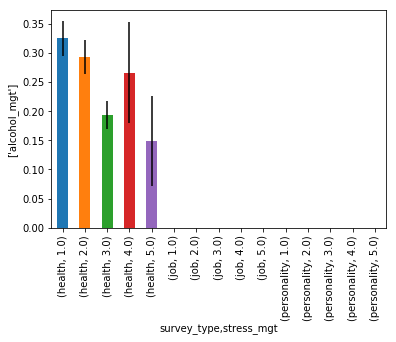

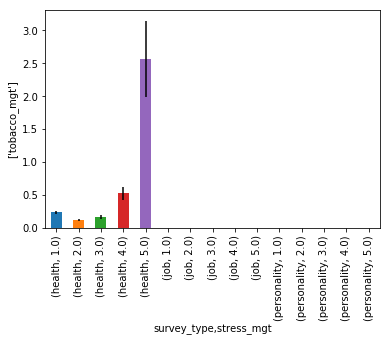

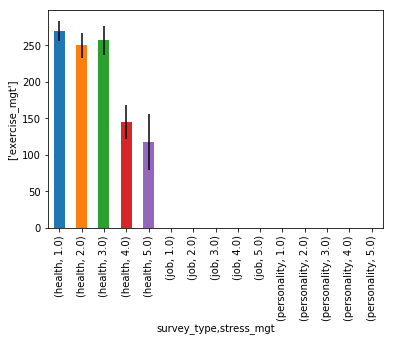

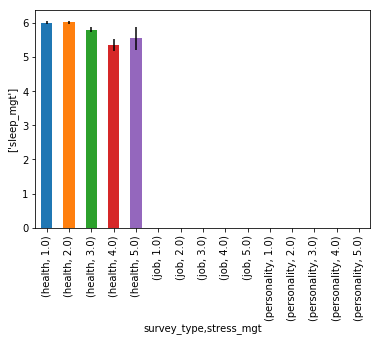

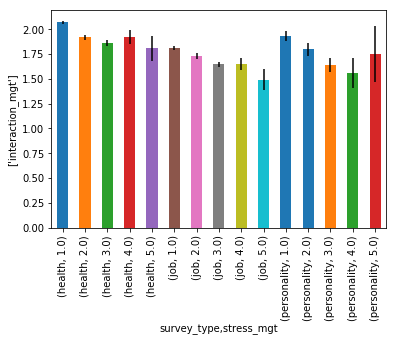

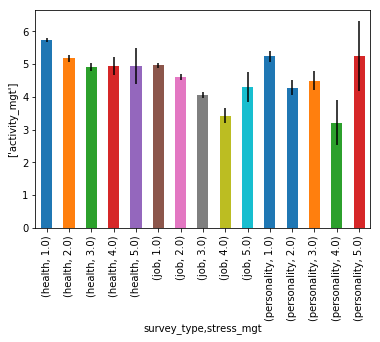

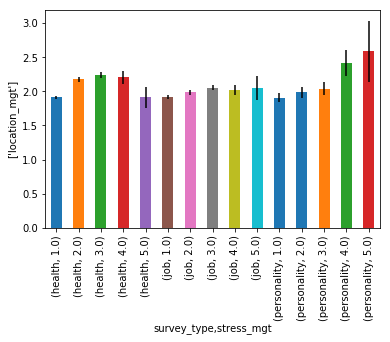

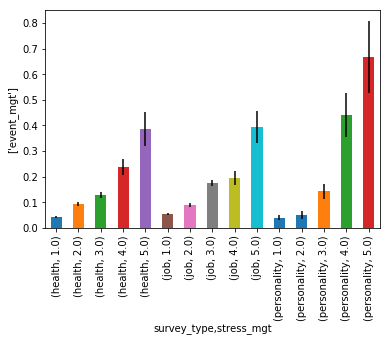

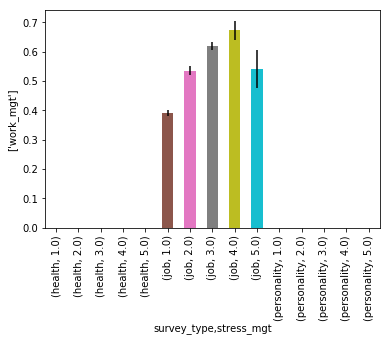

In [26]:
#lets look at how each parameter changes as a result of reported stress levels for each survey types (eg secondary question of whether survey type affects reponses)

#get column names (eg parameters)
parameters = data_EMA.groupby('stress_mgt').mean().columns.values

for param in parameters:
    data_EMA.groupby(['survey_type', 'stress_mgt'])[param].mean().plot(kind='bar', yerr=data_EMA.groupby(['survey_type', 'stress_mgt'])[param].sem())
    plt.ylabel([param])
    plt.show()

In [180]:
data_EMA.groupby('survey_type')['work_mgt'].unique()

survey_type
health                   [nan]
job            [1.0, 0.0, nan]
personality              [nan]
Name: work_mgt, dtype: object

In [27]:
#merge demog and EMA dfs
demo_EMA = data_EMA.merge(data_demog, on = 'uid', how = 'inner')
print(demo_EMA.shape)
demo_EMA.info()
demo_EMA.head()

(11398, 69)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 11398 entries, 0 to 11397
Data columns (total 69 columns):
uid                       11398 non-null object
survey_type               11398 non-null object
timestamp                 11398 non-null object
itp_mgt                   2371 non-null float64
irb_mgt                   2374 non-null float64
ocb_mgt                   2361 non-null float64
cwb_mgt                   2359 non-null float64
neu_mgt                   805 non-null float64
con_mgt                   802 non-null float64
ext_mgt                   805 non-null float64
agr_mgt                   805 non-null float64
ope_mgt                   805 non-null float64
pos_af_mgt                11278 non-null float64
neg_af_mgt                11277 non-null float64
anxiety_mgt               11287 non-null float64
stress_mgt                11312 non-null float64
alcohol_mgt               5553 non-null float64
tobacco_mgt               5551 non-null float64
exercise_mgt    

,uid,survey_type,timestamp,itp_mgt,irb_mgt,ocb_mgt,cwb_mgt,neu_mgt,con_mgt,ext_mgt,agr_mgt,ope_mgt,pos_af_mgt,neg_af_mgt,anxiety_mgt,stress_mgt,alcohol_mgt,tobacco_mgt,exercise_mgt,sleep_mgt,interaction_mgt,activity_mgt,location_mgt,event_mgt,work_mgt,date,time,ID,date_time,GenInst,gender,age,bornUS,lang,educ,jobstat,occup,supervise,size,duration,income,record_id,redcap_event_name,demographics_timestamp,race,ethnic,relationship,pregnant,children,housing,household___1,household___2,household___3,household___4,household___5,household___6,household___7,currentposition,certifications,nurseyears,shift,hours,overtime,commute_type,commute_time,extrajob,extrahours,student,demographics_complete
0,SD1001,job,2018-03-05 18:00:29,4.666666,49.0,7.0,2.0,NaN,NaN,NaN,NaN,NaN,11.0,5.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,8.0,2.0,0.0,1.0,2018-03-05,18:00:29,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
1,SD1001,health,2018-03-06 06:00:26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,6.0,1.0,1.0,1.0,0.0,0.0,5.0,3.0,1.0,2.0,0.0,NaN,2018-03-06,06:00:26,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
2,SD1001,job,2018-03-07 19:00:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,6.0,1.0,3.0,NaN,NaN,NaN,NaN,1.0,5.0,1.0,0.0,0.0,2018-03-07,19:00:57,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
3,SD1001,personality,2018-03-08 14:23:35,NaN,NaN,NaN,NaN,1.5,5.0,2.5,2.5,3.0,17.0,8.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,11.0,1.0,0.0,NaN,2018-03-08,14:23:35,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2
4,SD1001,health,2018-03-09 07:27:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.0,8.0,2.0,3.0,0.0,0.0,0.0,6.0,3.0,3.0,4.0,0.0,NaN,2018-03-09,07:27:27,SD1001,2/20/2018,1,1,53,2,2,4,2,11,2,4,10,7,7,prestudy_survey_arm_1,2018-02-21 12:42:29,7,1,2,0,0,1,1,1,1,0,0,0,0,7,7,30,1,36,0,2,3,0,0,9,2


In [28]:
demo_EMA.groupby(['gender', 'survey_type', 'stress_mgt'])['uid'].count()

gender  survey_type  stress_mgt
1       health       1.0            845
                     2.0            393
                     3.0            316
                     4.0             70
                     5.0             18
        job          1.0            735
                     2.0            302
                     3.0            300
                     4.0             65
                     5.0             16
        personality  1.0            123
                     2.0             61
                     3.0             37
                     4.0              9
                     5.0              2
2       health       1.0           2029
                     2.0           1012
                     3.0            749
                     4.0            116
                     5.0             39
        job          1.0           1657
                     2.0            889
                     3.0            764
                     4.0            146
        

In [184]:
param + '.png'

'itp_mgt.png'

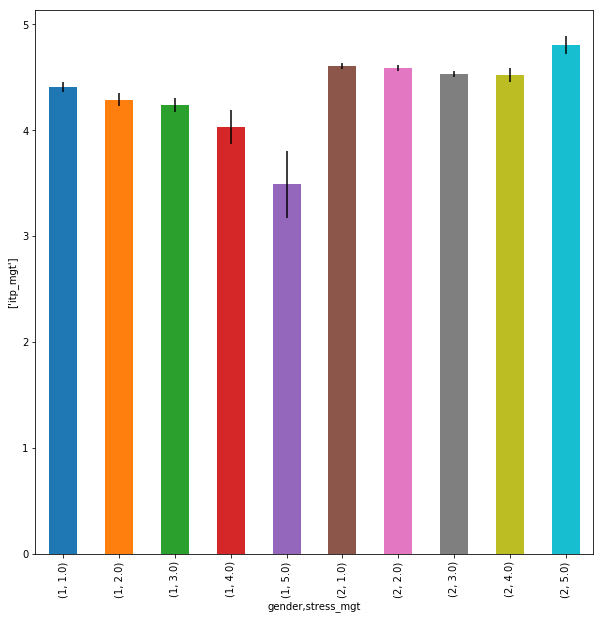

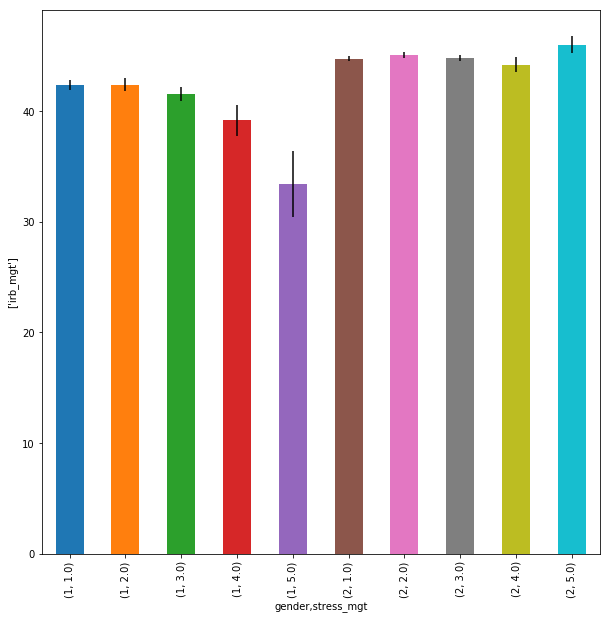

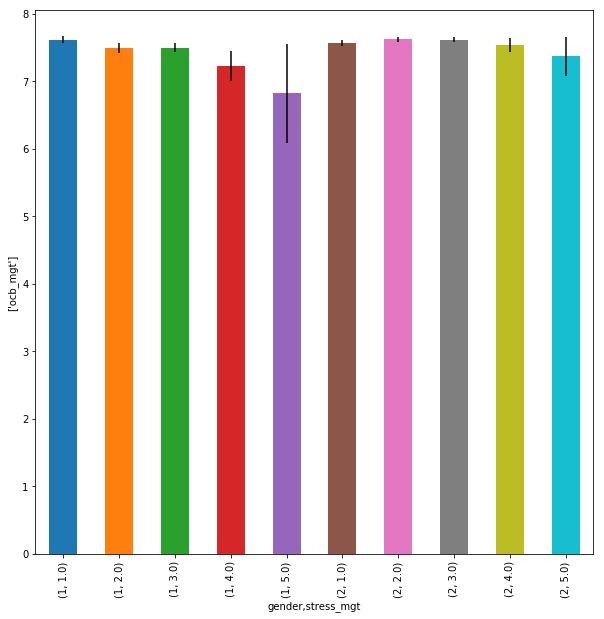

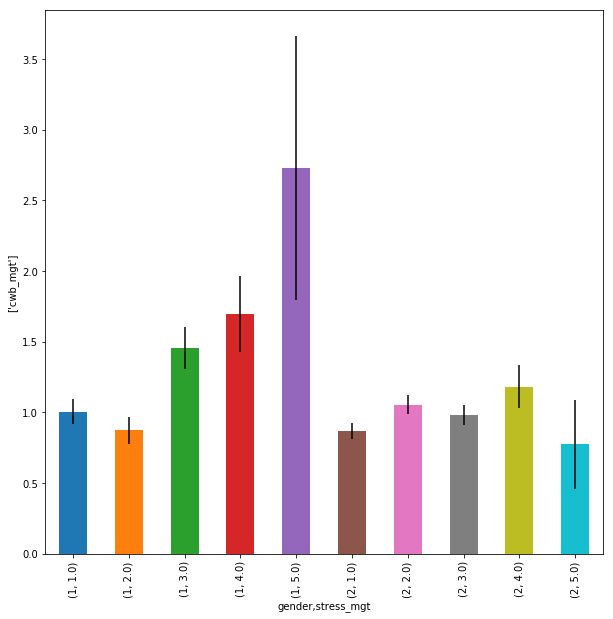

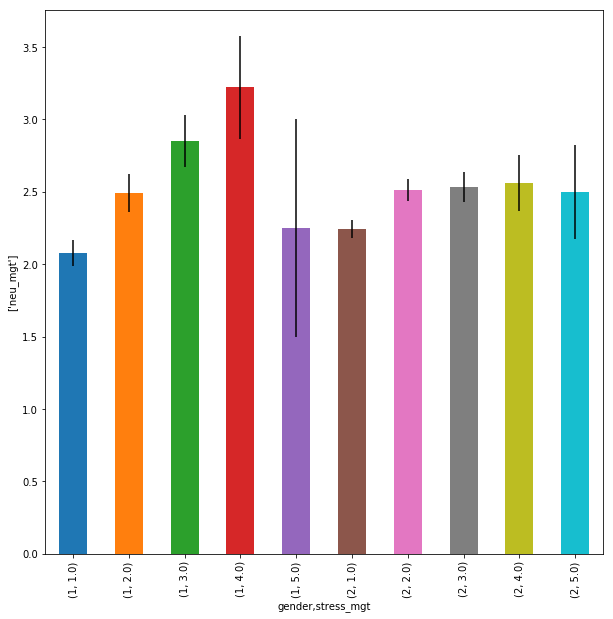

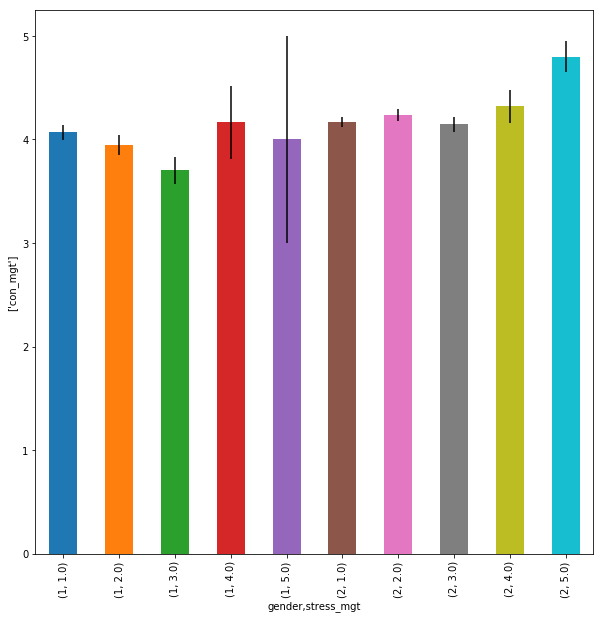

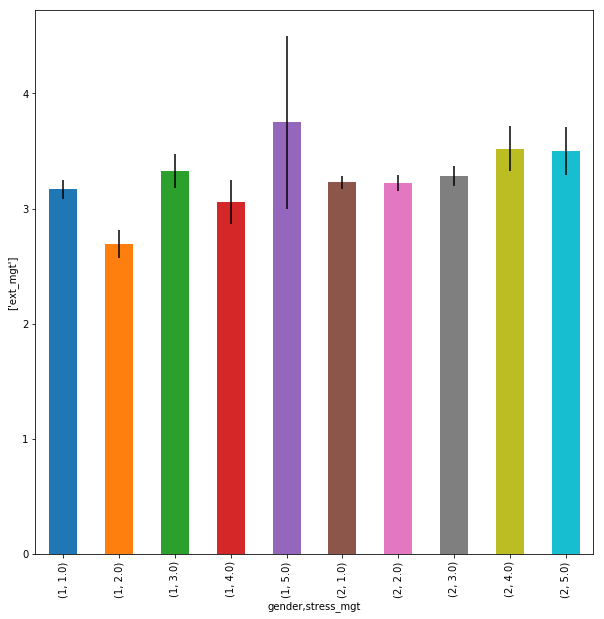

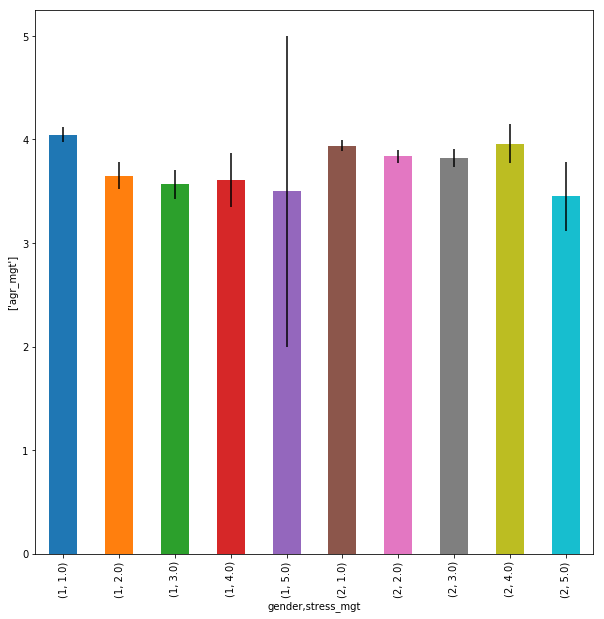

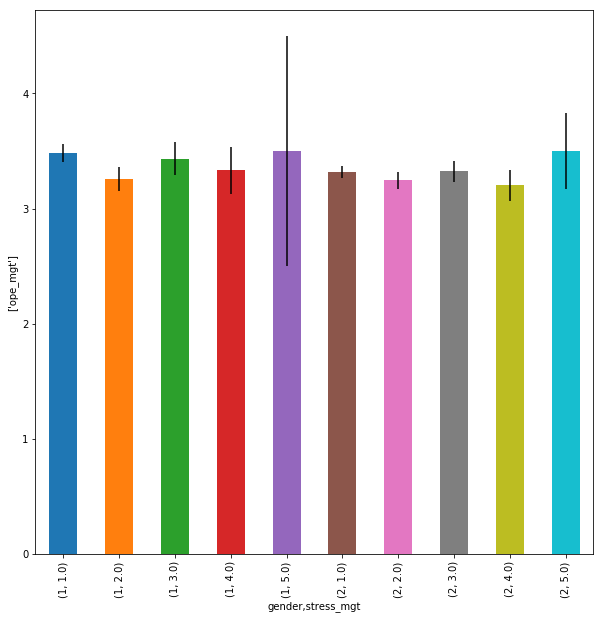

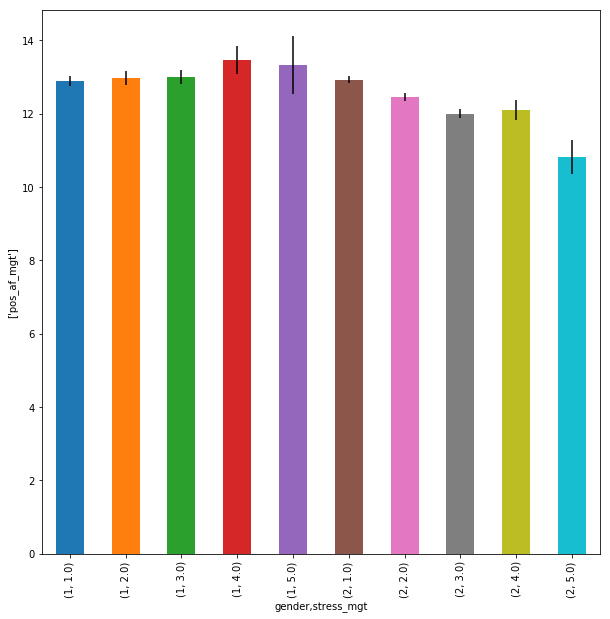

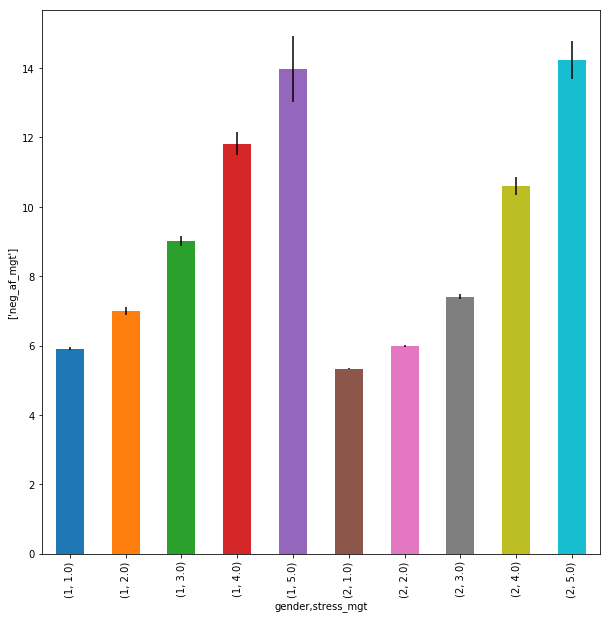

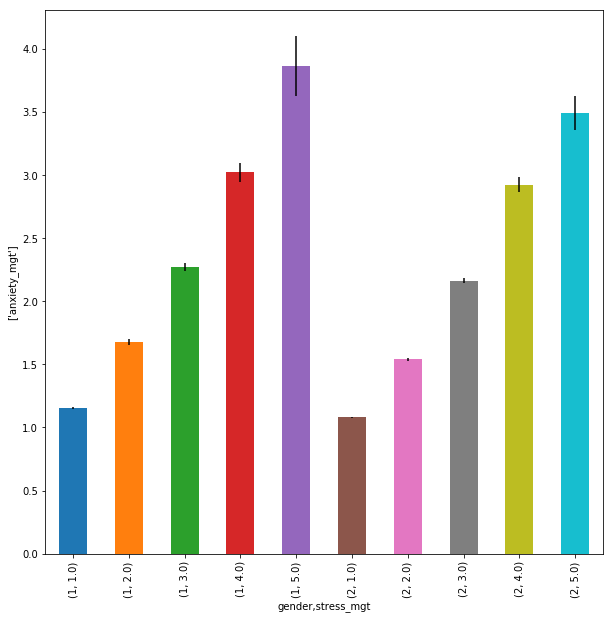

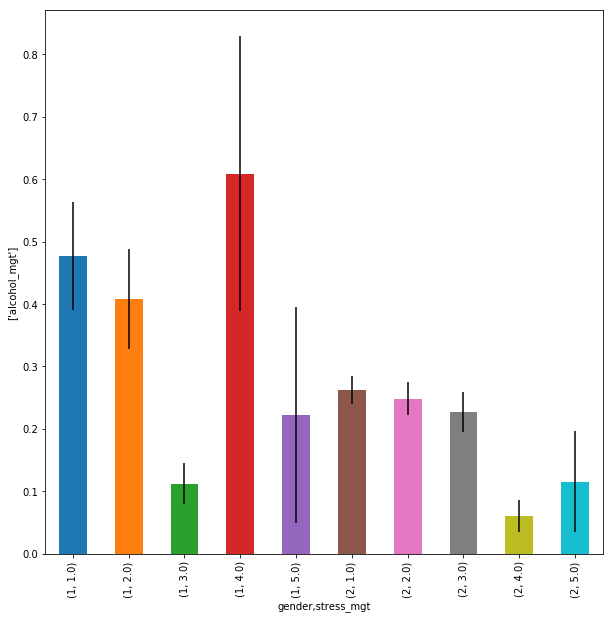

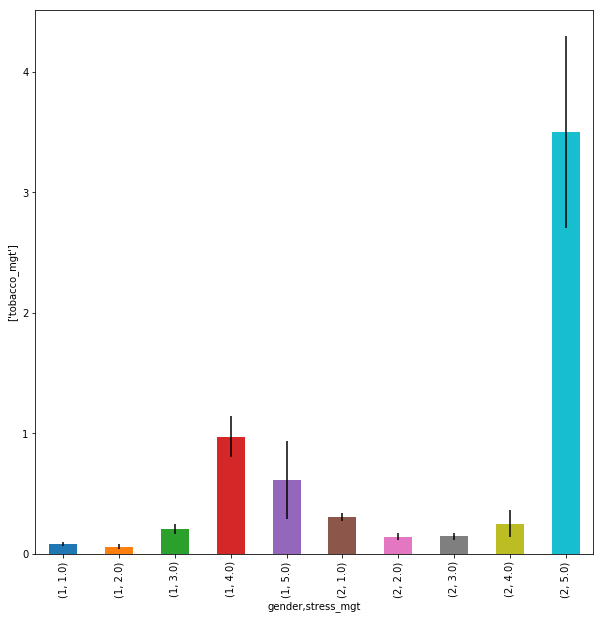

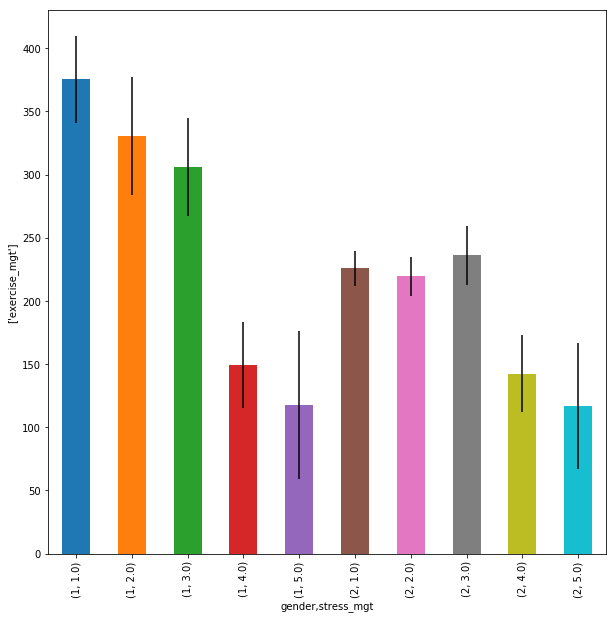

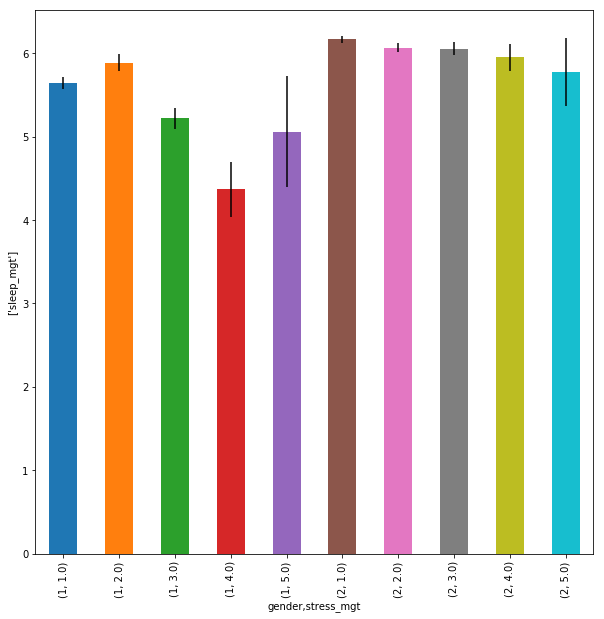

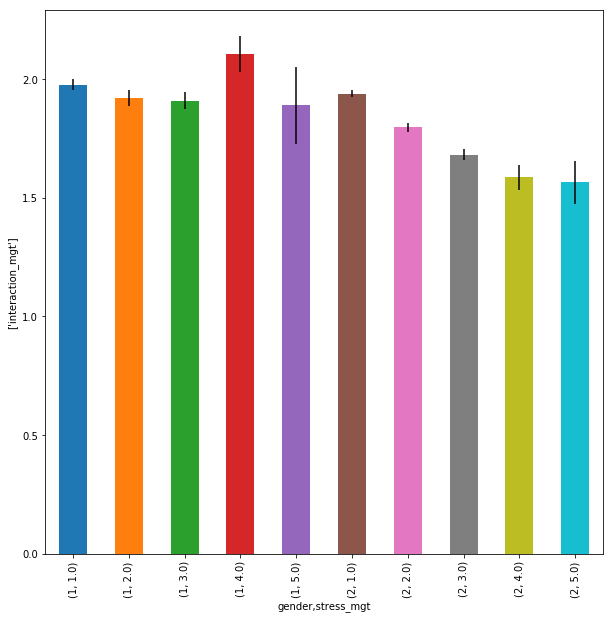

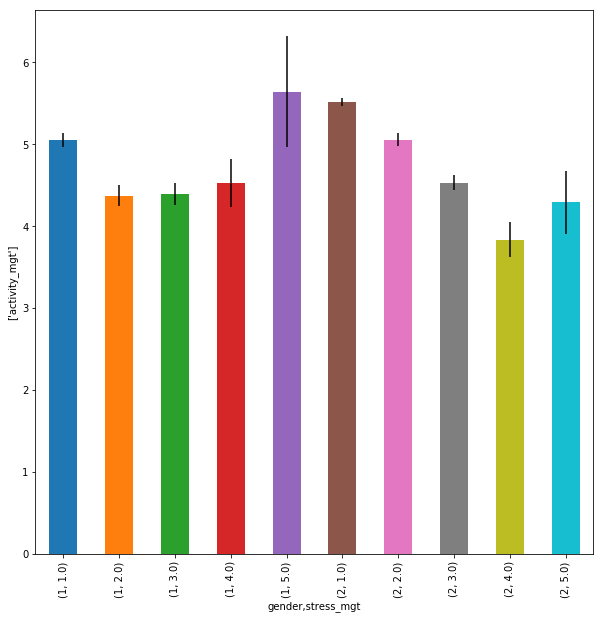

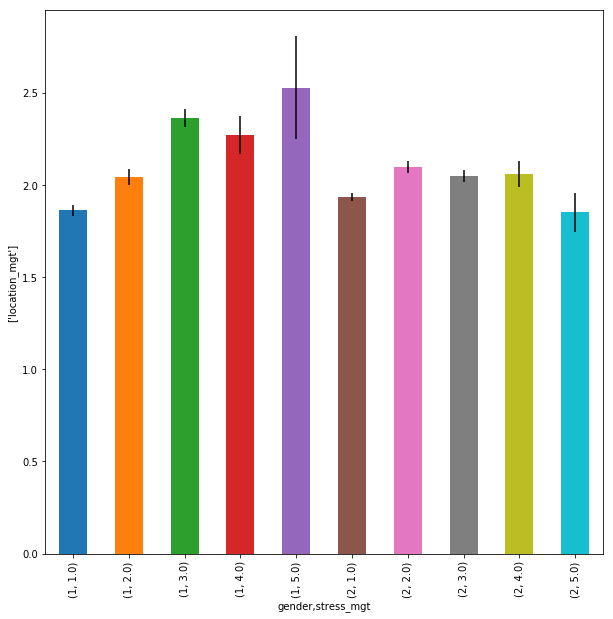

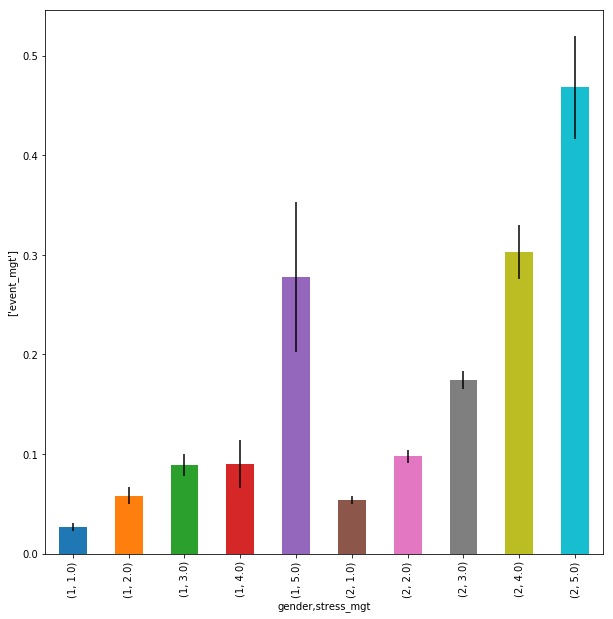

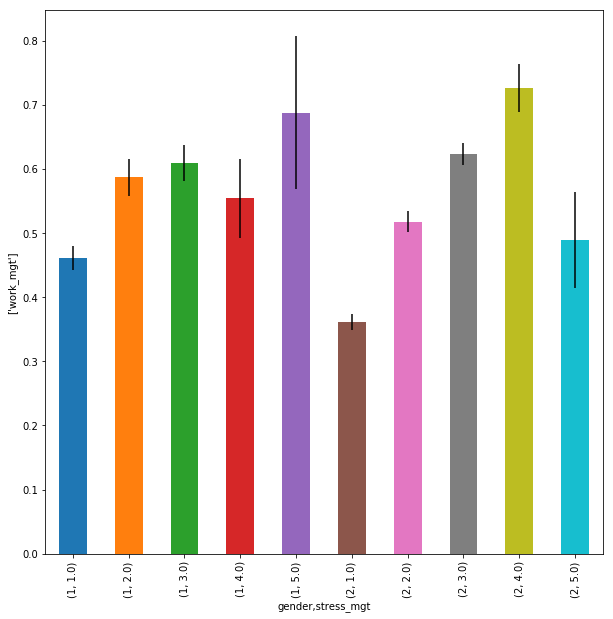

In [189]:
#lets look at how each parameter changes as a result of reported stress levels for each survey type and across gender

#get column names (eg parameters)
parameters = data_EMA.groupby('stress_mgt').mean().columns.values

for param in parameters:
    plt.figure(figsize=(10,10))
    demo_EMA.groupby(['gender', 'stress_mgt'])[param].mean().plot(kind='bar', yerr=demo_EMA.groupby(['gender', 'stress_mgt'])[param].sem())
    plt.ylabel([param])
    plt.savefig(str(param + '.png'))
    plt.show()

In [ ]:
#create separate data frame for each survey
print('Health EMA data', '\n')
print('Missing values per column', '\n', data[data['survey_type'] == 'health'].isnull().sum(), '\n')
data_health = data[data['survey_type'] == 'health'].dropna(thresh = 100, axis = 1)
print(data_health.shape, '\n', '\n')

print('Job EMA data', '\n')
print('Missing values per column', '\n', data[data['survey_type'] == 'job'].isnull().sum(), '\n')
data_job = data[data['survey_type'] == 'job'].dropna(thresh = 100, axis = 1)
print(data_job.shape, '\n', '\n')

print('Personality EMA data', '\n')
print('Missing values per column', '\n', data[data['survey_type'] == 'personality'].isnull().sum(), '\n')
data_personality = data[data['survey_type'] == 'personality'].dropna(thresh = 100, axis = 1)
print(data_personality.shape, '\n', '\n')